<a href="https://colab.research.google.com/github/prismacon/cassandra/blob/master/LSTM_10_15_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/prismacon/psda2020-exercise3-rnn-lstm-pipeline/blob/master/Model_pipeline.ipynb)

# Setup storage

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import dependencies

In [5]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from random import sample
from tqdm import tqdm
import plotly.graph_objects as go


In [6]:
df = pd.read_csv("drive/My Drive/PSDA 2020 Exercise 3 Data/Csv_data/all.csv", index_col=[0])
display(df)

,left_acc_x,left_acc_y,left_acc_z,left_gyr_x,left_gyr_y,left_gyr_z,left_quat_w,left_quat_x,left_quat_y,left_quat_z,hip_acc_x,hip_acc_y,hip_acc_z,hip_gyr_x,hip_gyr_y,hip_gyr_z,hip_quat_w,hip_quat_x,hip_quat_y,hip_quat_z,right_acc_x,right_acc_y,right_acc_z,right_gyr_x,right_gyr_y,right_gyr_z,right_quat_w,right_quat_x,right_quat_y,right_quat_z,rtls_accuracy,rtls_accuracy_radius,rtls_mapped_position,rtls_state,rtls_x_filtered,rtls_x_unfiltered,rtls_y_filtered,rtls_y_unfiltered,rtls_z_filtered,rtls_z_unfiltered,label,id
2020-05-26 08:04:14.120,-0.219889,-0.481445,-0.724284,-2.234163,-1.024139,-0.543110,0.669796,0.350221,-0.594804,0.273585,-0.058105,0.763346,0.311686,0.241934,0.023413,0.066337,0.061358,0.808043,0.094697,-0.578216,0.235677,1.509928,-0.299642,-1.073449,-0.692456,1.059259,0.011814,-0.673664,0.358302,0.645980,0.0,0.0,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
2020-05-26 08:04:14.140,0.157715,-0.911621,0.000000,-1.587824,-0.408662,-0.025541,0.682057,0.343657,-0.585584,0.271586,-0.044922,0.843750,0.312988,-0.085138,-0.105358,0.026606,0.062371,0.807224,0.094346,-0.579308,0.500488,0.030273,-0.340332,3.420420,-1.994358,-0.268185,0.012550,-0.647711,0.342284,0.680294,0.0,0.0,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
2020-05-26 08:04:14.160,0.078125,-0.699219,0.000488,0.219230,0.220295,-0.110679,0.685126,0.340926,-0.582634,0.273695,-0.019043,0.946777,0.304688,-0.040441,0.064918,-0.088331,0.062654,0.807496,0.094727,-0.578837,0.210449,0.408691,-0.040527,2.470067,-1.248336,-0.666205,0.012896,-0.637094,0.334999,0.694061,0.0,0.0,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
2020-05-26 08:04:14.180,0.116211,-0.741211,-0.258626,0.784689,0.472871,-0.222068,0.678902,0.349042,-0.586143,0.271380,-0.006348,0.965658,0.335286,-0.013480,0.140123,-0.077688,0.061188,0.807621,0.094754,-0.578814,0.159017,0.625814,0.039551,1.442735,-0.385604,-0.808102,0.022569,-0.624732,0.322383,0.710798,0.0,0.0,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
2020-05-26 08:04:14.200,-0.110840,-1.037109,-0.567871,2.065661,1.073803,-0.128771,0.663965,0.362933,-0.595742,0.269003,0.004395,0.996582,0.363281,-0.021285,0.090459,-0.041505,0.059158,0.807807,0.094314,-0.578838,0.070801,0.552246,-0.176758,0.467195,0.584260,-0.774756,0.034869,-0.623037,0.319589,0.713050,0.0,0.0,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-26 18:07:01.200,-0.580078,-0.984538,-0.343913,0.482094,-4.256191,-1.744975,0.342945,-0.490375,-0.273338,-0.752820,-0.029785,0.969238,0.284668,-0.008514,-0.098973,-0.035119,0.613283,-0.094937,0.779998,0.080464,-0.331706,1.053711,0.552572,-1.477499,-4.178148,-0.252576,0.047951,-0.634551,0.370333,0.676346,0.0,0.0,-1.0,1.0,3.057509,3.064015,1.384443,1.362724,2.326005,2.519745,0.0,29
2020-05-26 18:07:01.220,-0.625000,-0.854980,-0.353027,-0.045762,-4.401635,-1.484594,0.298254,-0.504422,-0.239510,-0.774104,-0.012207,0.951660,0.299316,0.009578,-0.003193,-0.021285,0.613191,-0.095385,0.779993,0.080681,-0.278320,1.057129,0.339844,-1.216409,-4.609159,-0.363965,0.028337,-0.642108,0.349333,0.681807,0.0,0.0,-1.0,1.0,3.057509,3.064015,1.384443,1.362723,2.326005,2.519745,0.0,29
2020-05-26 18:07:01.240,-0.705078,-0.825195,-0.502441,0.068110,-4.489966,-1.493108,0.280677,-0.509885,-0.226557,-0.780615,-0.011719,0.942139,0.291504,0.021817,-0.021285,-0.019156,0.613178,-0.095742,0.779982,0.080466,-0.280029,1.195068,0.247803,-1.249932,-4.857656,-0.304901,0.003986,0.652462,-0.314827,-0.689319,0.0,0.0,-1.0,1.0,3.057509,3.064015,1.384443,1.362723,2.326005,2.519745,0.0,29
2020-05-26 18:07:01.260,-2.483236,1.871094,-4.249674,5.843660,-0.360063,-2.737187,0.248654,-0.555116,-0.236941,-0.756464,0.017090,0.946777,0.257812,0.004257,-0.061725,-0.006385,0.613259,-0.096295,0.779801,0.080943,-0.340007

# Data exploration

In [7]:
# What is visualized， What information can be obtained

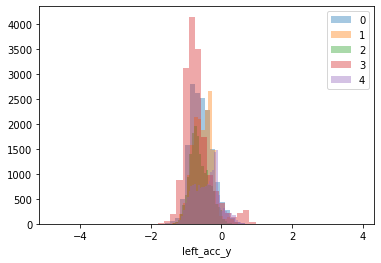

In [8]:
import seaborn as sns
for index,id_ in enumerate([0,6,12,18,24]):
    a = df[df.id == id_]
    sns.distplot(a['left_acc_y'],  kde=False, label=str(index))
plt.legend()
plt.show()

# The distribution of sensor values is related to the person. ----- Preprocessing time series difference

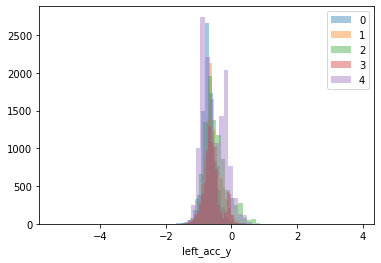

In [9]:
import seaborn as sns
for index,id_ in enumerate([0,6,12,18,24]):
    a = df[df.id == id_+1]
    sns.distplot(a['left_acc_y'],  kde=False, label=str(index))
plt.legend()
plt.show()

# The distribution of sensor values is related to the person. ----- Preprocessing time series difference

# Preprocessing 

##  train test split 

In [10]:
train = []
test = []
for id_ in df["id"].unique():
    temp = df[df["id"]==id_]
    train.append(temp.iloc[0:int(temp.shape[0]*0.8)])
    test.append(temp.iloc[int(temp.shape[0]*0.8):])
train = pd.concat(train)
test = pd.concat(test)

display(test)

,left_acc_x,left_acc_y,left_acc_z,left_gyr_x,left_gyr_y,left_gyr_z,left_quat_w,left_quat_x,left_quat_y,left_quat_z,hip_acc_x,hip_acc_y,hip_acc_z,hip_gyr_x,hip_gyr_y,hip_gyr_z,hip_quat_w,hip_quat_x,hip_quat_y,hip_quat_z,right_acc_x,right_acc_y,right_acc_z,right_gyr_x,right_gyr_y,right_gyr_z,right_quat_w,right_quat_x,right_quat_y,right_quat_z,rtls_accuracy,rtls_accuracy_radius,rtls_mapped_position,rtls_state,rtls_x_filtered,rtls_x_unfiltered,rtls_y_filtered,rtls_y_unfiltered,rtls_z_filtered,rtls_z_unfiltered,label,id
2020-05-26 08:08:26.100,-0.346680,-1.335938,0.225586,0.428883,-0.054275,-0.098973,0.420318,0.188091,-0.744273,0.483748,0.194824,0.931641,0.149902,0.081945,0.076624,-0.051083,0.290800,0.700401,0.342576,-0.554541,-0.429199,1.000977,-0.544922,-0.680040,1.097216,0.273506,0.347968,0.426697,0.274614,-0.788284,0.0,0.0,-1.0,1.0,3.067457,3.208292,1.291228,1.050609,2.656575,2.843557,1.0,0
2020-05-26 08:08:26.120,-0.448242,-0.528320,0.238281,-0.788591,-0.073432,-0.100037,0.422331,0.187752,-0.743662,0.483057,0.116211,0.884277,0.202637,-0.007450,-0.112808,-0.100037,0.290873,0.699827,0.343592,-0.554597,-0.448730,0.937500,-0.561523,-0.881178,1.179161,0.449103,0.343076,0.438617,0.266124,-0.786773,0.0,0.0,-1.0,1.0,3.067457,3.208292,1.291228,1.050609,2.656575,2.843557,1.0,0
2020-05-26 08:08:26.140,-0.451172,-0.494141,0.238770,0.104294,-0.120257,-0.067046,0.424620,0.186675,-0.742609,0.483096,-0.011719,0.931641,0.262695,-0.083010,-0.371415,-0.135157,0.293060,0.698255,0.348052,-0.552645,-0.375000,0.837891,-0.563965,-1.297290,1.447346,0.658755,0.340226,0.445637,0.261439,-0.785686,0.0,0.0,-1.0,1.0,3.067457,3.208292,1.291228,1.050609,2.656575,2.843557,1.0,0
2020-05-26 08:08:26.160,-0.510742,-0.766602,0.282715,0.129126,-0.101811,-0.043633,0.424569,0.187042,-0.743492,0.481638,-0.116699,0.995605,0.215820,-0.040441,-0.528920,-0.097909,0.294123,0.697688,0.349229,-0.552047,-0.309570,0.805664,-0.511230,-1.386685,1.585696,0.719061,0.333456,0.468889,0.247028,-0.779620,0.0,0.0,-1.0,1.0,3.067457,3.208292,1.291228,1.050609,2.656575,2.843557,1.0,0
2020-05-26 08:08:26.180,-0.540039,-0.831543,0.223633,-0.195817,-0.142606,-0.119193,0.425892,0.186911,-0.743641,0.480288,-0.134766,1.021484,0.151367,0.036184,-0.443782,-0.005321,0.297684,0.695928,0.352482,-0.550292,-0.266602,0.718750,-0.453125,-1.233437,1.647421,0.798169,0.327481,0.488981,0.232698,-0.774206,0.0,0.0,-1.0,1.0,3.067457,3.208292,1.291228,1.050609,2.656575,2.843557,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-26 18:07:01.200,-0.580078,-0.984538,-0.343913,0.482094,-4.256191,-1.744975,0.342945,-0.490375,-0.273338,-0.752820,-0.029785,0.969238,0.284668,-0.008514,-0.098973,-0.035119,0.613283,-0.094937,0.779998,0.080464,-0.331706,1.053711,0.552572,-1.477499,-4.178148,-0.252576,0.047951,-0.634551,0.370333,0.676346,0.0,0.0,-1.0,1.0,3.057509,3.064015,1.384443,1.362724,2.326005,2.519745,0.0,29
2020-05-26 18:07:01.220,-0.625000,-0.854980,-0.353027,-0.045762,-4.401635,-1.484594,0.298254,-0.504422,-0.239510,-0.774104,-0.012207,0.951660,0.299316,0.009578,-0.003193,-0.021285,0.613191,-0.095385,0.779993,0.080681,-0.278320,1.057129,0.339844,-1.216409,-4.609159,-0.363965,0.028337,-0.642108,0.349333,0.681807,0.0,0.0,-1.0,1.0,3.057509,3.064015,1.384443,1.362723,2.326005,2.519745,0.0,29
2020-05-26 18:07:01.240,-0.705078,-0.825195,-0.502441,0.068110,-4.489966,-1.493108,0.280677,-0.509885,-0.226557,-0.780615,-0.011719,0.942139,0.291504,0.021817,-0.021285,-0.019156,0.613178,-0.095742,0.779982,0.080466,-0.280029,1.195068,0.247803,-1.249932,-4.857656,-0.304901,0.003986,0.652462,-0.314827,-0.689319,0.0,0.0,-1.0,1.0,3.057509,3.064015,1.384443,1.362723,2.326005,2.519745,0.0,29
2020-05-26 18:07:01.260,-2.483236,1.871094,-4.249674,5.843660,-0.360063,-2.737187,0.248654,-0.555116,-0.236941,-0.756464,0.017090,0.946777,0.257812,0.004257,-0.061725,-0.006385,0.613259,-0.096295,0.779801,0.080943,-

In [11]:
# leave one proband out
train = df[df["id"]<24]
test = df[df["id"]>=24]


## feature selection and normalisation

In [12]:
train_features = train.iloc[:,:-2] # [Christian] remove last 2 columns "label" and "id", only leave feature columns in this table
test_features = test.iloc[:,:-2] # [Christian] remove last 2 columns "label" and "id", only leave feature columns in this table

# check if feature is unique, and delete it
unique_counts = train_features.nunique()
record_single_unique = pd.DataFrame(unique_counts[unique_counts == 1]).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
display(record_single_unique)
to_drop = list(record_single_unique['feature'])
print(to_drop) # [Christian] these columns only used a single value, so they are not helpful for learning
train_features = train_features.drop(columns = to_drop)
test_features = test_features.drop(columns = to_drop)


,feature,nunique
0,rtls_accuracy,1
1,rtls_accuracy_radius,1
2,rtls_mapped_position,1


['rtls_accuracy', 'rtls_accuracy_radius', 'rtls_mapped_position']


In [13]:
# # sigmoid transformation

Interquartile0_25 = np.array(train_features.quantile(0.25))
Interquartile0_75 = np.array(train_features.quantile(0.75))
IQR = Interquartile0_75 - Interquartile0_25

# Median for each features
median = np.array(train_features.median())

feature_columns = train_features.columns
# drop the features which has fast 0.0 Interquartile
position = np.where( IQR == 0 )[0] # [Christian] this means that lots of values are similar, so they don't contribute to learning much  
train_features.drop(train_features.columns[position], axis=1, inplace = True)
test_features.drop(test_features.columns[position], axis=1, inplace = True)
median = np.delete(median,position)
IQR = np.delete(IQR,position)

# sigmoid transformation
train_features = (1+np.exp((-train_features + median)/(IQR*1.35)))**(-1)
test_features = (1+np.exp((-test_features + median)/(IQR*1.35)))**(-1)
train = pd.concat([train_features,train.iloc[:,-2:]],axis=1)
test = pd.concat([test_features,test.iloc[:,-2:]],axis=1)
display(train_features)
display(test_features)

,left_acc_x,left_acc_y,left_acc_z,left_gyr_x,left_gyr_y,left_gyr_z,left_quat_w,left_quat_x,left_quat_y,left_quat_z,hip_acc_x,hip_acc_y,hip_acc_z,hip_gyr_x,hip_gyr_y,hip_gyr_z,hip_quat_w,hip_quat_x,hip_quat_y,hip_quat_z,right_acc_x,right_acc_y,right_acc_z,right_gyr_x,right_gyr_y,right_gyr_z,right_quat_w,right_quat_x,right_quat_y,right_quat_z,rtls_state,rtls_x_filtered,rtls_x_unfiltered,rtls_y_filtered,rtls_y_unfiltered,rtls_z_filtered,rtls_z_unfiltered
2020-05-26 08:04:14.120,0.632393,0.561343,0.330908,0.150828,0.222586,0.329380,0.621090,0.694837,0.422475,0.566236,0.496633,0.315582,0.484059,0.646440,0.508939,0.547184,0.308279,0.594139,0.289595,0.410862,0.738667,0.814842,0.457928,0.336198,0.346954,0.765822,0.356345,0.393694,0.564358,0.578523,0.677158,0.497292,0.497927,0.470599,0.466637,0.523347,0.522166
2020-05-26 08:04:14.140,0.770646,0.366716,0.503633,0.226099,0.373823,0.493148,0.626567,0.693181,0.424995,0.565840,0.505724,0.408156,0.484881,0.435902,0.470341,0.518510,0.308791,0.593994,0.289459,0.410571,0.809024,0.222300,0.447822,0.904044,0.135918,0.424830,0.356745,0.399538,0.558890,0.583092,0.677158,0.497292,0.497927,0.470599,0.466637,0.523347,0.522166
2020-05-26 08:04:14.160,0.744760,0.461375,0.503755,0.540133,0.558495,0.465093,0.627933,0.692491,0.425802,0.566257,0.523552,0.535997,0.479641,0.465028,0.521379,0.435546,0.308934,0.594042,0.289606,0.410697,0.731158,0.365151,0.522742,0.835454,0.240096,0.321020,0.356933,0.401938,0.556399,0.584921,0.677158,0.497292,0.497927,0.470599,0.466637,0.523347,0.522166
2020-05-26 08:04:14.180,0.757382,0.442206,0.439777,0.644798,0.631022,0.428745,0.625161,0.694540,0.424842,0.565799,0.532278,0.559409,0.498971,0.482726,0.543842,0.443148,0.308192,0.594064,0.289617,0.410703,0.715432,0.462103,0.542720,0.722421,0.414455,0.287382,0.362206,0.404737,0.552077,0.587142,0.677158,0.497292,0.497927,0.470599,0.466637,0.523347,0.522166
2020-05-26 08:04:14.200,0.676084,0.314828,0.366121,0.829564,0.778000,0.459154,0.618474,0.698030,0.422218,0.565328,0.539647,0.597148,0.516660,0.477597,0.529022,0.469175,0.307167,0.594097,0.289447,0.410696,0.687213,0.428539,0.488623,0.579790,0.636719,0.295097,0.368959,0.405121,0.551119,0.587440,0.677158,0.497292,0.497927,0.470599,0.466637,0.523347,0.522166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-26 11:39:53.800,0.785296,0.316059,0.508962,0.632698,0.913815,0.459037,0.357186,0.775399,0.610667,0.648156,0.457900,0.497148,0.451287,0.573263,0.471508,0.506430,0.605335,0.485223,0.584339,0.510398,0.784985,0.691899,0.560352,0.492616,0.532951,0.441719,0.357663,0.702112,0.355737,0.400601,0.500000,0.523785,0.514893,0.476549,0.487442,0.496376,0.506207
2020-05-26 11:39:53.820,0.793570,0.307210,0.558651,0.556265,0.903398,0.460026,0.350111,0.776936,0.615649,0.646711,0.460855,0.505500,0.458889,0.543674,0.472092,0.503472,0.605991,0.485010,0.584204,0.510667,0.753689,0.655804,0.563284,0.499221,0.539343,0.485839,0.356320,0.702044,0.355769,0.400543,0.500000,0.523785,0.514893,0.476549,0.487442,0.496376,0.506207
2020-05-26 11:39:53.840,0.792077,0.334559,0.580088,0.501093,0.895412,0.475948,0.345042,0.776987,0.619075,0.646527,0.470405,0.545104,0.458123,0.503503,0.462396,0.477638,0.606119,0.484936,0.584223,0.510770,0.774914,0.669218,0.566532,0.454265,0.566514,0.486286,0.355565,0.702337,0.355215,0.400831,0.500000,0.523785,0.514893,0.476549,0.487442,0.496376,0.506207
2020-05-26 11:39:53.860,0.798976,0.361784,0.623096,0.384924,0.858711,0.470692,0.341876,0.776541,0.621145,0.646807,0.465152,0.550352,0.461598,0.498132,0.459539,0.470969,0.606275,0.484728,0.584377,0.511003,0.738475,0.592674,0.575164,0.550993,0.519475,0.524334,0.355248,0.701987,0.355054,0.400613,0.500000,0.523785,0.514893,0.476549,0.487442,0.496376,0.506207


,left_acc_x,left_acc_y,left_acc_z,left_gyr_x,left_gyr_y,left_gyr_z,left_quat_w,left_quat_x,left_quat_y,left_quat_z,hip_acc_x,hip_acc_y,hip_acc_z,hip_gyr_x,hip_gyr_y,hip_gyr_z,hip_quat_w,hip_quat_x,hip_quat_y,hip_quat_z,right_acc_x,right_acc_y,right_acc_z,right_gyr_x,right_gyr_y,right_gyr_z,right_quat_w,right_quat_x,right_quat_y,right_quat_z,rtls_state,rtls_x_filtered,rtls_x_unfiltered,rtls_y_filtered,rtls_y_unfiltered,rtls_z_filtered,rtls_z_unfiltered
2020-05-26 17:16:22.980,0.843402,0.260021,0.508235,0.526571,0.322564,0.214020,0.527076,0.737439,0.501703,0.636700,0.522880,0.665562,0.453683,0.403833,0.503352,0.516198,0.589640,0.504800,0.572986,0.503074,0.829023,0.291749,0.565931,0.776024,0.375331,0.752891,0.456132,0.701130,0.400486,0.398314,0.5,0.440818,0.445803,0.443011,0.443350,0.391844,0.290126
2020-05-26 17:16:23.000,0.851021,0.393106,0.477004,0.610767,0.458958,0.247926,0.529372,0.739382,0.502008,0.634807,0.542991,0.654039,0.501235,0.431085,0.542046,0.516583,0.589162,0.504921,0.573115,0.503020,0.825613,0.532210,0.607674,0.493943,0.482347,0.623531,0.459104,0.700155,0.398861,0.397957,0.5,0.440818,0.445803,0.443011,0.443350,0.391844,0.290126
2020-05-26 17:16:23.020,0.823473,0.356123,0.436040,0.481845,0.492695,0.402015,0.530395,0.739168,0.502619,0.634851,0.545330,0.607687,0.495679,0.544717,0.557219,0.532362,0.588937,0.505172,0.572806,0.502705,0.801300,0.569471,0.457523,0.518683,0.614586,0.658641,0.459820,0.700128,0.398140,0.398035,0.5,0.440818,0.445803,0.443011,0.443350,0.391844,0.290126
2020-05-26 17:16:23.040,0.721569,0.493025,0.437113,0.405617,0.598946,0.526155,0.530308,0.738733,0.503369,0.635418,0.531049,0.501222,0.437672,0.569832,0.493295,0.534411,0.589396,0.505143,0.572576,0.502735,0.799870,0.584007,0.451133,0.643854,0.601148,0.595912,0.458920,0.699084,0.395029,0.397533,0.5,0.440818,0.445803,0.443011,0.443350,0.391844,0.290126
2020-05-26 17:16:23.060,0.740125,0.388820,0.414729,0.565850,0.792041,0.493324,0.527282,0.739715,0.505489,0.636296,0.552666,0.484420,0.445282,0.501751,0.519945,0.552277,0.589719,0.505186,0.572350,0.502765,0.758778,0.444962,0.483977,0.714203,0.554751,0.528002,0.456814,0.697113,0.392910,0.396310,0.5,0.440818,0.445803,0.443011,0.443350,0.391844,0.290126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-26 18:07:01.200,0.475996,0.336097,0.419047,0.589832,0.006004,0.091259,0.468048,0.456153,0.511816,0.363383,0.516156,0.563823,0.467023,0.485992,0.472251,0.473789,0.622718,0.429219,0.595538,0.590582,0.542919,0.654479,0.664969,0.280271,0.020011,0.429110,0.376197,0.402513,0.568455,0.582567,0.5,0.443418,0.446699,0.470000,0.461738,0.322435,0.435079
2020-05-26 18:07:01.220,0.456179,0.391283,0.416847,0.489213,0.005051,0.124068,0.446937,0.452016,0.521273,0.359424,0.528253,0.542071,0.476252,0.497898,0.500958,0.483802,0.622666,0.429138,0.595536,0.590640,0.563080,0.655906,0.615926,0.315770,0.013464,0.398833,0.365366,0.400804,0.561298,0.583293,0.5,0.443418,0.446699,0.470000,0.461738,0.322435,0.435079
2020-05-26 18:07:01.240,0.421235,0.404435,0.381314,0.511128,0.004548,0.122851,0.438682,0.450409,0.524891,0.358217,0.528588,0.530216,0.471328,0.505955,0.495530,0.485344,0.622659,0.429074,0.595531,0.590583,0.562437,0.710947,0.593882,0.311078,0.010702,0.414807,0.352107,0.693391,0.337505,0.398065,0.5,0.443418,0.446699,0.470000,0.461738,0.322435,0.435079
2020-05-26 18:07:01.260,0.030170,0.989880,0.014747,0.988919,0.387501,0.026369,0.423733,0.437145,0.521991,0.362704,0.548333,0.535997,0.450166,0.494396,0.483403,0.494599,0.622705,0.428974,0.595449,0.590710,0.539769,0.754209,0.533069,0.351503,0.007251,0.426094,0.378239,0.695085,0.353459,0.396649,0.5,0.443418,0.446699,0.470000,0.461738,0.322435,0.435079


# Data generator

In [14]:
def batch_generator(df, half_window = 15, batch_size = 90, validation=False,val=0.1):
    
    df_to_sample = df.reset_index(drop=True)
    candidate_index = []
    for id_ in df["id"].unique():
        candidate_index.extend(list(df_to_sample[df_to_sample["id"]==id_].index[half_window:-half_window]))
    candidate_index = sorted(candidate_index)
    # [Christian] measurements from all probands without the first and last 15 measurements
    df_to_sample = df_to_sample.loc[candidate_index]
    other_index=list(df_to_sample[df_to_sample["label"]==0].index) # [Christian] changed to "label", before was "id"
    other_val_index = sample(other_index, int(len(other_index)*val))
    other_index = list(set(other_index).difference(set(other_val_index)))
   
    take_index=list(df_to_sample[df_to_sample["label"]==1].index) # [Christian] changed to "label", before was "id"
    take_val_index = sample(take_index, int(len(take_index)*val))
    take_index = list(set(take_index).difference(set(take_val_index)))
    

    trop_index=list(df_to_sample[df_to_sample["label"]==2].index) # [Christian] changed to "label", before was "id"
    trop_val_index = sample(trop_index, int(len(trop_index)*val))
    trop_index = list(set(trop_index).difference(set(trop_val_index)))
    # split the remaining measurement indices in 90/10 % for train/validation


    df_to_sample = df.reset_index(drop=True)
    df_to_sample.drop(['id'],axis=1, inplace=True)
    df_to_sample = pd.concat([df_to_sample,pd.get_dummies(df_to_sample['label'], prefix='action')],axis=1)
    df_to_sample.drop(['label'],axis=1, inplace=True)
   
    print(df_to_sample.shape)
    while True:
        x_batch = []
        y_batch = []
        if not validation:
            for i in range(int(batch_size/3)):
                index= random.randint(0,len(other_index)-1)
                x_batch.append(df_to_sample.iloc[other_index[index]-half_window:other_index[index]+half_window,:-3].values)
                y_batch.append(df_to_sample.iloc[other_index[index],-3:].values)

                index= random.randint(0,len(trop_index)-1)
                x_batch.append(df_to_sample.iloc[trop_index[index]-half_window:trop_index[index]+half_window,:-3].values)
                y_batch.append(df_to_sample.iloc[trop_index[index],-3:].values)

                index= random.randint(0,len(take_index)-1)
                x_batch.append(df_to_sample.iloc[take_index[index]-half_window:take_index[index]+half_window,:-3].values)
                y_batch.append(df_to_sample.iloc[take_index[index],-3:].values)
            x_batch = np.array(x_batch)
            y_batch = np.array(y_batch)
            yield x_batch, y_batch
        else:
            for i in range(int(batch_size/3)):
                index= random.randint(0,len(other_val_index)-1)
                x_batch.append(df_to_sample.iloc[other_val_index[index]-half_window:other_val_index[index]+half_window,:-3].values)
                y_batch.append(df_to_sample.iloc[other_val_index[index],-3:].values)

                index= random.randint(0,len(trop_val_index)-1)
                x_batch.append(df_to_sample.iloc[trop_val_index[index]-half_window:trop_val_index[index]+half_window,:-3].values)
                y_batch.append(df_to_sample.iloc[trop_val_index[index],-3:].values)

                index= random.randint(0,len(take_val_index)-1)
                x_batch.append(df_to_sample.iloc[take_val_index[index]-half_window:take_val_index[index]+half_window,:-3].values)
                y_batch.append(df_to_sample.iloc[take_val_index[index],-3:].values)

            x_batch = np.array(x_batch)
            y_batch = np.array(y_batch)
            yield x_batch, y_batch

# Model training

In [15]:
half_window = 15
batch_size = 90
feature_number = train.shape[1]-2
n_outputs = 3

In [16]:
model = Sequential()
model.add(LSTM(10, input_shape=(half_window*2,feature_number), return_sequences=True))
model.add(LSTM(10, input_shape=(half_window*2,feature_number), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [17]:
model.fit_generator(batch_generator(train),steps_per_epoch=max(1, int(df.shape[0]*0.9)//batch_size),
                    validation_data=batch_generator(train,validation=True), validation_steps=max(1, int(df.shape[0]*0.1)//batch_size),
                    epochs=15,
                    initial_epoch=0)

Epoch 1/15
(267875, 40)
(267875, 40)
3518/3518 [==============================] - 361s 102ms/step - loss: 0.5700 - accuracy: 0.7420 - val_loss: 0.5594 - val_accuracy: 0.6001
Epoch 2/15
3518/3518 [==============================] - 353s 100ms/step - loss: 0.4788 - accuracy: 0.7997 - val_loss: 0.5773 - val_accuracy: 0.7856
Epoch 3/15
3518/3518 [==============================] - 353s 100ms/step - loss: 0.4490 - accuracy: 0.8140 - val_loss: 0.5434 - val_accuracy: 0.7034
Epoch 4/15
3518/3518 [==============================] - 353s 100ms/step - loss: 0.4259 - accuracy: 0.8234 - val_loss: 0.5376 - val_accuracy: 0.7921
Epoch 5/15
3518/3518 [==============================] - 356s 101ms/step - loss: 0.4074 - accuracy: 0.8321 - val_loss: 0.5667 - val_accuracy: 0.7556
Epoch 6/15
3518/3518 [==============================] - 356s 101ms/step - loss: 0.3902 - accuracy: 0.8398 - val_loss: 0.5259 - val_accuracy: 0.7667
Epoch 7/15
3518/3518 [==============================] - 354s 101ms/step - loss: 0.3783

# Post processing

# Evaluation

In [18]:
label = test["label"].values
start = 10000
end = 12000
random_x = np.linspace(0, end-start, end-start+1)
display(random_x)
# Create traces
fig = go.Figure()

fig.add_trace(go.Scatter(x=random_x, y=label[start:end],
                    mode='markers+lines',
                    name='prediction'))


fig.show()

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.998e+03, 1.999e+03,
       2.000e+03])

In [19]:
test_copy = test.copy()
test_copy.reset_index(drop=True,inplace=True)
candidate_index = []
for id_ in test_copy["id"].unique():
    candidate_index.extend(list(test_copy[test_copy["id"]==id_].index[half_window:-half_window]))
candidate_index = sorted(candidate_index)
predict = []
for index in tqdm(candidate_index):
    input_x = test_copy.iloc[index-half_window:index+half_window,:-2]
    input_x =np.expand_dims(input_x,0)
    predict.append(np.argmax(model.predict(input_x)))
    
groud = list(test_copy.loc[candidate_index,"label"].values)

100%|██████████| 83813/83813 [06:01<00:00, 232.03it/s]


In [20]:
baseline= [0]*len(groud)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(baseline, groud)

0.7687112977700357

In [22]:
accuracy_score(predict, groud)

0.7865963514013339

In [23]:
import plotly.graph_objects as go
import plotly.express as px

In [24]:
random_x = np.linspace(0, 1, len(groud[2000:5000]))


# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=groud[2000:5000],
                    mode='markers+lines',
                    name='groud'))
fig.add_trace(go.Scatter(x=random_x, y=predict[2000:5000], mode='markers+lines', name='prediction'))


fig.show()